In [80]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from src.load_data import load_data

In [82]:
df=load_data()

In [83]:
df

,No.,Diameter (mm),Speed (rpm),Feed (mm/rev),Thrust force (N),Torque (Nm),Flank wear (mm),Workpiece
0,1,9.0,500,0.13,1088.1,10.67,0.10,cast iron
1,2,9.0,500,0.18,1435.1,14.66,0.13,cast iron
2,3,9.0,500,0.25,1588.3,16.04,0.06,cast iron
3,4,9.0,500,0.36,1669.8,17.12,0.09,cast iron
4,5,9.0,400,0.13,1150.9,11.22,0.12,cast iron
...,...,...,...,...,...,...,...,...
160,161,10.0,1000,0.50,1960.0,18.13,0.13,copper
161,162,7.5,1000,0.50,784.0,7.35,0.10,copper
162,163,5.0,1000,0.50,651.0,6.17,0.07,copper
163,164,10.0,1000,0.71,2009.0,20.58,0.17,copper


In [84]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   No.               165 non-null    int64  
 1   Diameter (mm)     165 non-null    float64
 2   Speed (rpm)       165 non-null    int64  
 3   Feed (mm/rev)     165 non-null    float64
 4   Thrust force (N)  165 non-null    float64
 5   Torque (Nm)       165 non-null    float64
 6   Flank wear (mm)   165 non-null    float64
 7   Workpiece         165 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 10.4+ KB


In [85]:
df.describe() 

,No.,Diameter (mm),Speed (rpm),Feed (mm/rev),Thrust force (N),Torque (Nm),Flank wear (mm)
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,83.000000,8.663636,506.272727,0.293152,1686.770303,17.712564,0.123738
std,47.775517,2.270008,221.237274,0.164119,1039.892128,7.896846,0.080592
min,1.000000,5.000000,250.000000,0.130000,186.000000,1.960000,0.010000
25%,42.000000,7.500000,315.000000,0.180000,784.000000,12.640000,0.082000
50%,83.000000,9.000000,400.000000,0.250000,1504.800000,17.120000,0.110000
75%,124.000000,10.000000,630.000000,0.360000,2473.000000,23.580000,0.150000
max,165.000000,12.000000,1000.000000,0.710000,4181.000000,36.220000,0.940000


In [86]:
from src.clean_data import clean_dataset

In [87]:
df = load_data()
df_clean = clean_dataset(df)
df_clean.head()


,no.,diameter_(mm),speed_(rpm),feed_(mm/rev),thrust_force_(n),torque_(nm),flank_wear_(mm),workpiece
0,1,9.0,500,0.13,1088.1,10.67,0.10,cast iron
1,2,9.0,500,0.18,1435.1,14.66,0.13,cast iron
2,3,9.0,500,0.25,1588.3,16.04,0.06,cast iron
3,4,9.0,500,0.36,1669.8,17.12,0.09,cast iron
4,5,9.0,400,0.13,1150.9,11.22,0.12,cast iron


In [88]:
from src.visualise_data import visualize

In [89]:
df = load_data()
df_clean = clean_dataset(df)


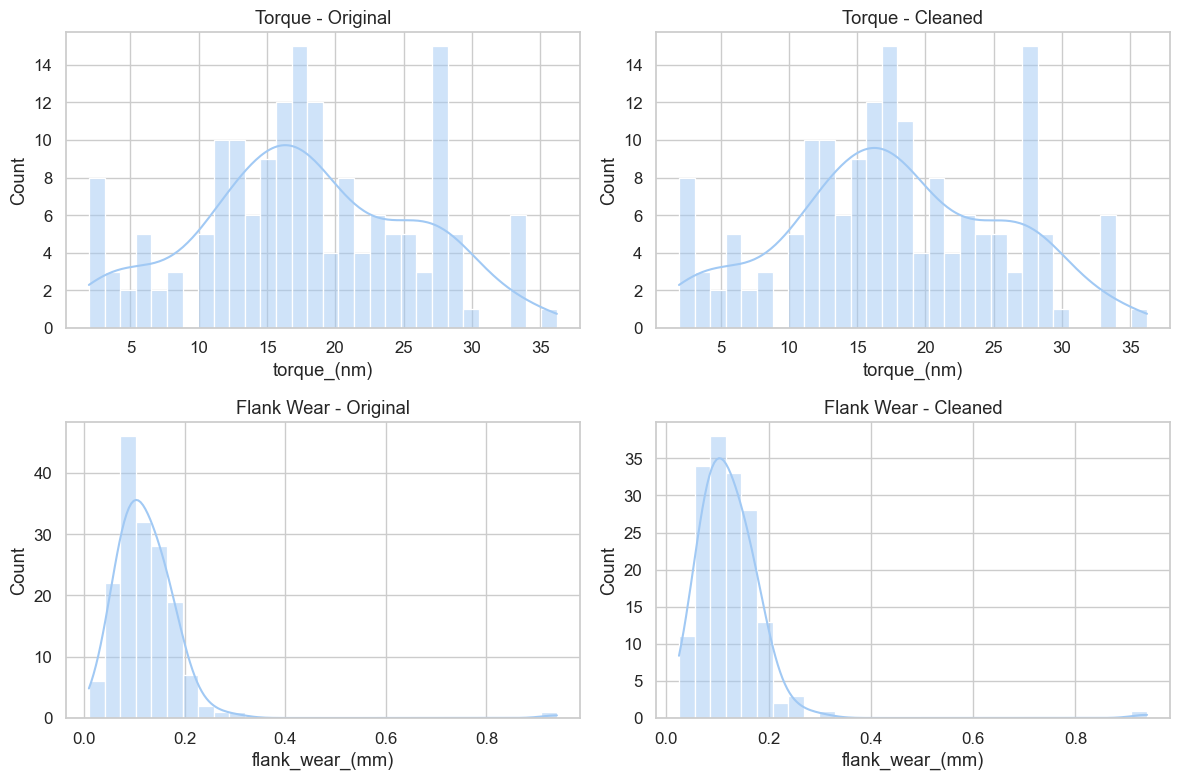

In [90]:
# Compare before and after cleaning
import matplotlib.pyplot as plt
import seaborn as sns

# Re-load original data for comparison
df_orig = load_data()
df_orig.columns = df_orig.columns.str.strip().str.lower().str.replace(' ', '_')

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df_orig['torque_(nm)'], bins=30, ax=axs[0,0], kde=True)
axs[0,0].set_title("Torque - Original")

sns.histplot(df_clean['torque_(nm)'], bins=30, ax=axs[0,1], kde=True)
axs[0,1].set_title("Torque - Cleaned")

sns.histplot(df_orig['flank_wear_(mm)'], bins=30, ax=axs[1,0], kde=True)
axs[1,0].set_title("Flank Wear - Original")

sns.histplot(df_clean['flank_wear_(mm)'], bins=30, ax=axs[1,1], kde=True)
axs[1,1].set_title("Flank Wear - Cleaned")

plt.tight_layout()
plt.show()


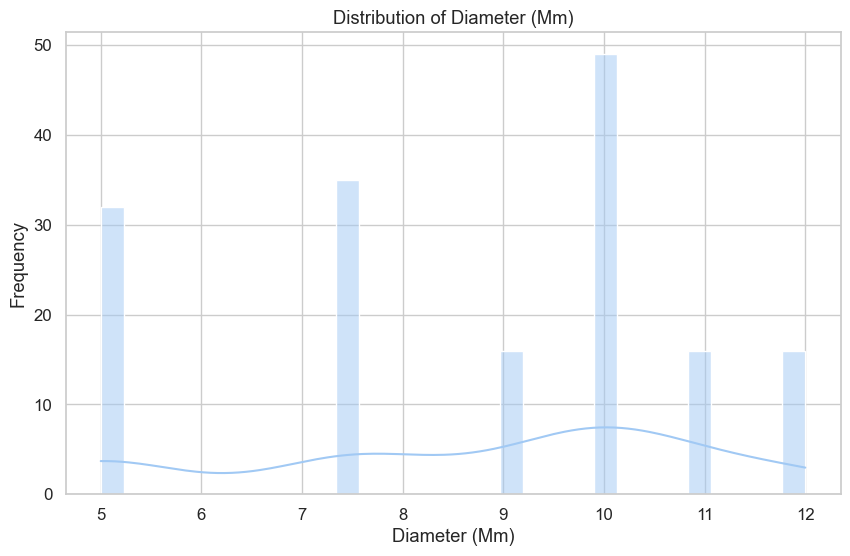

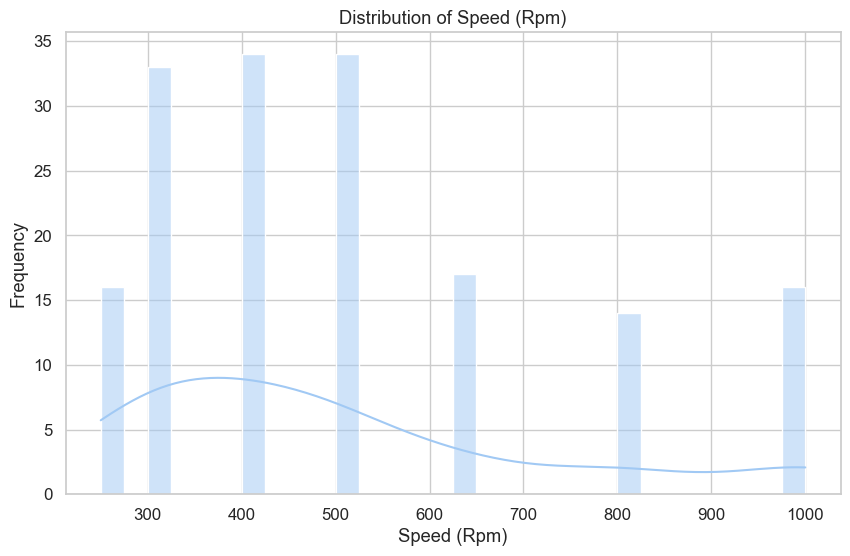

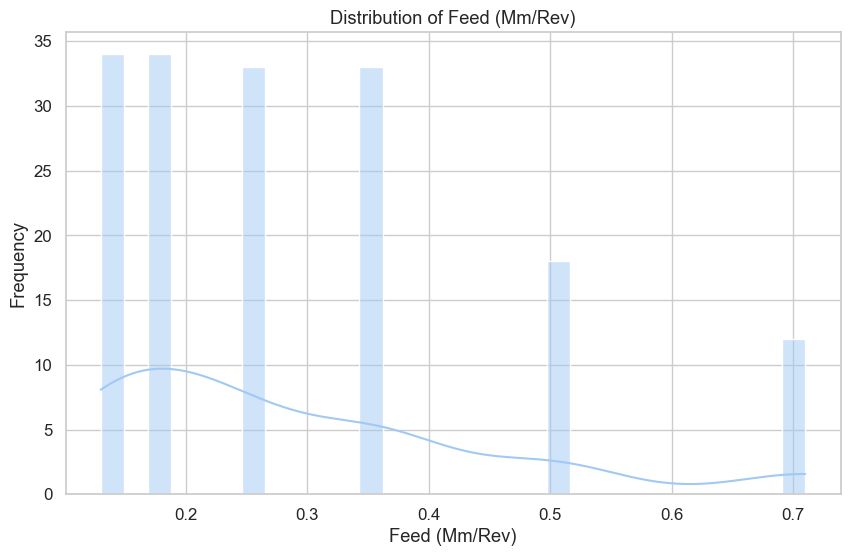

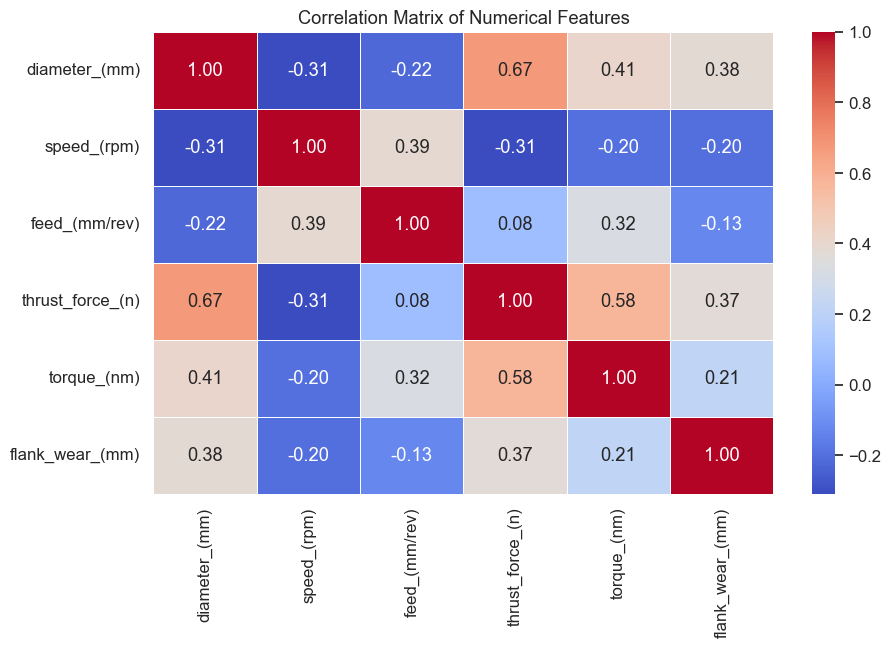

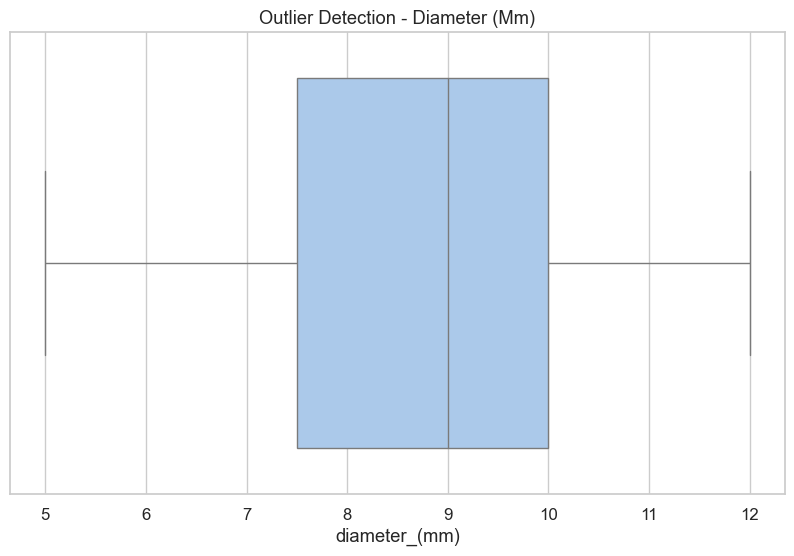

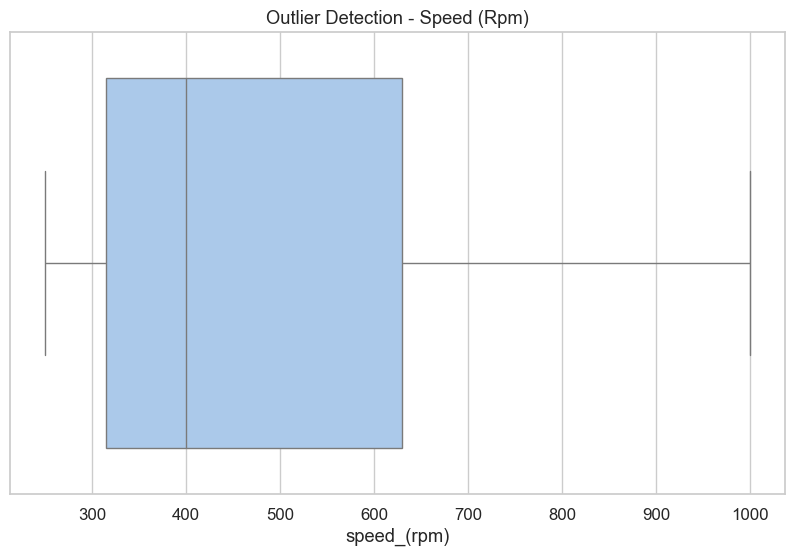

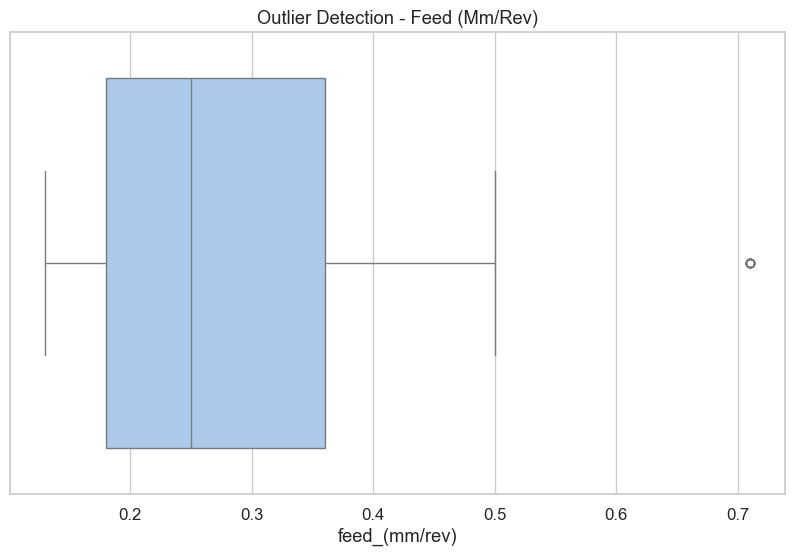

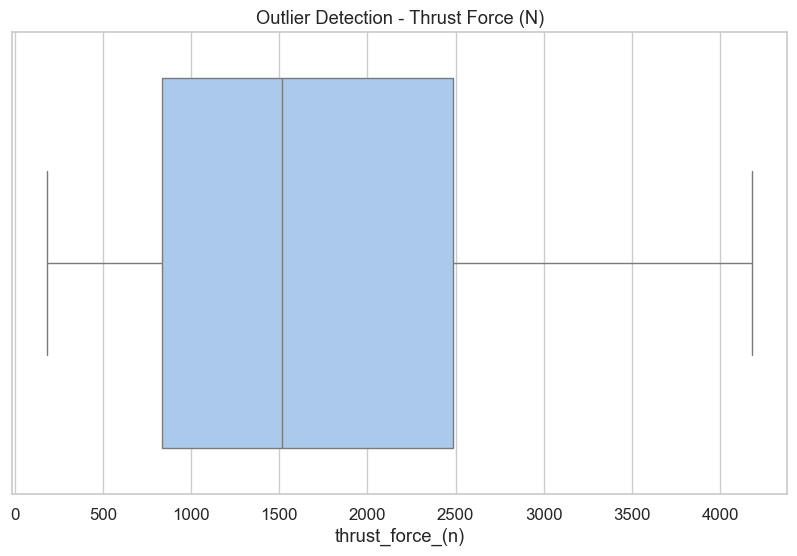

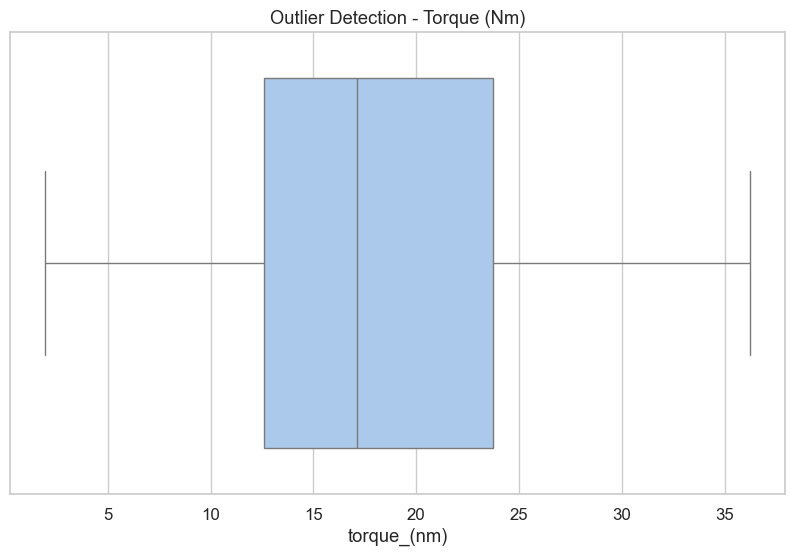

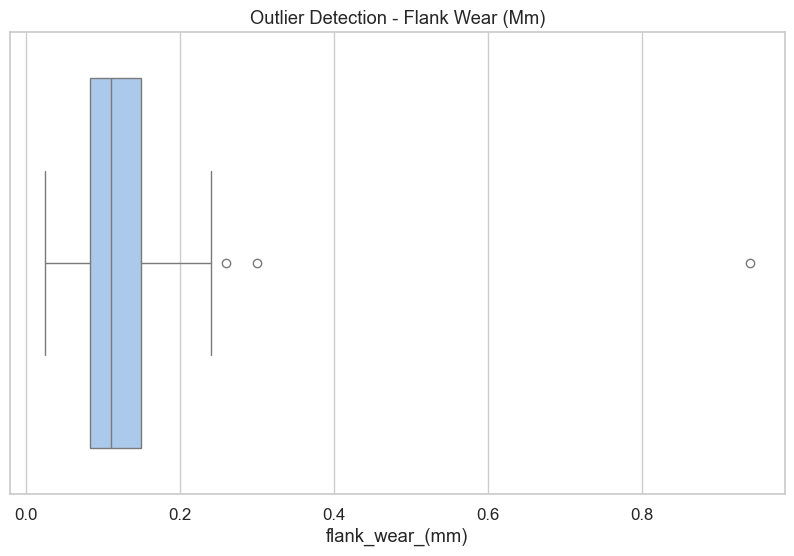

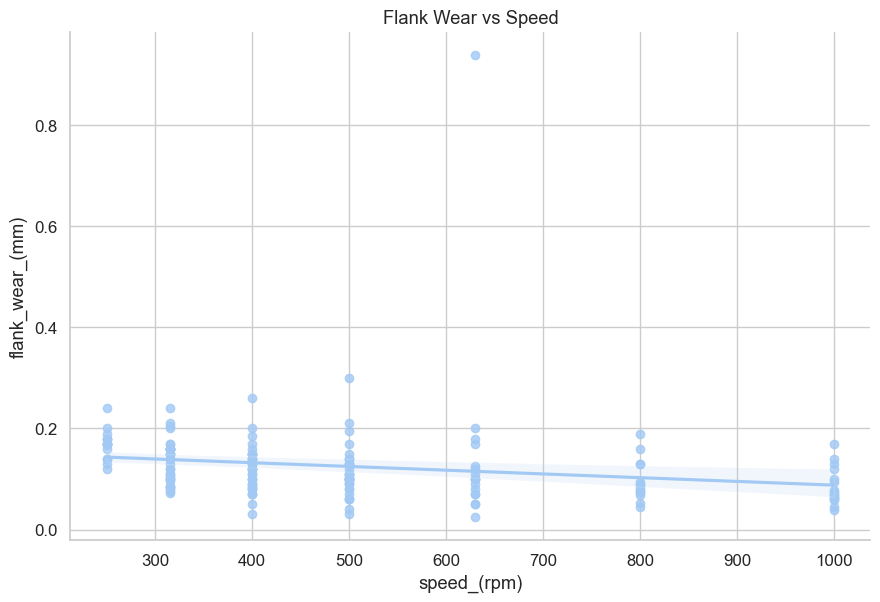

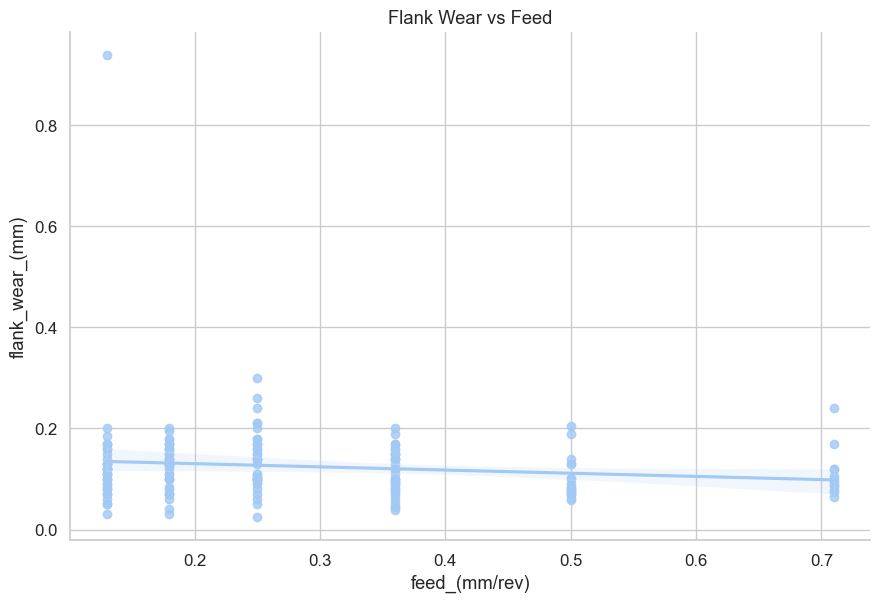

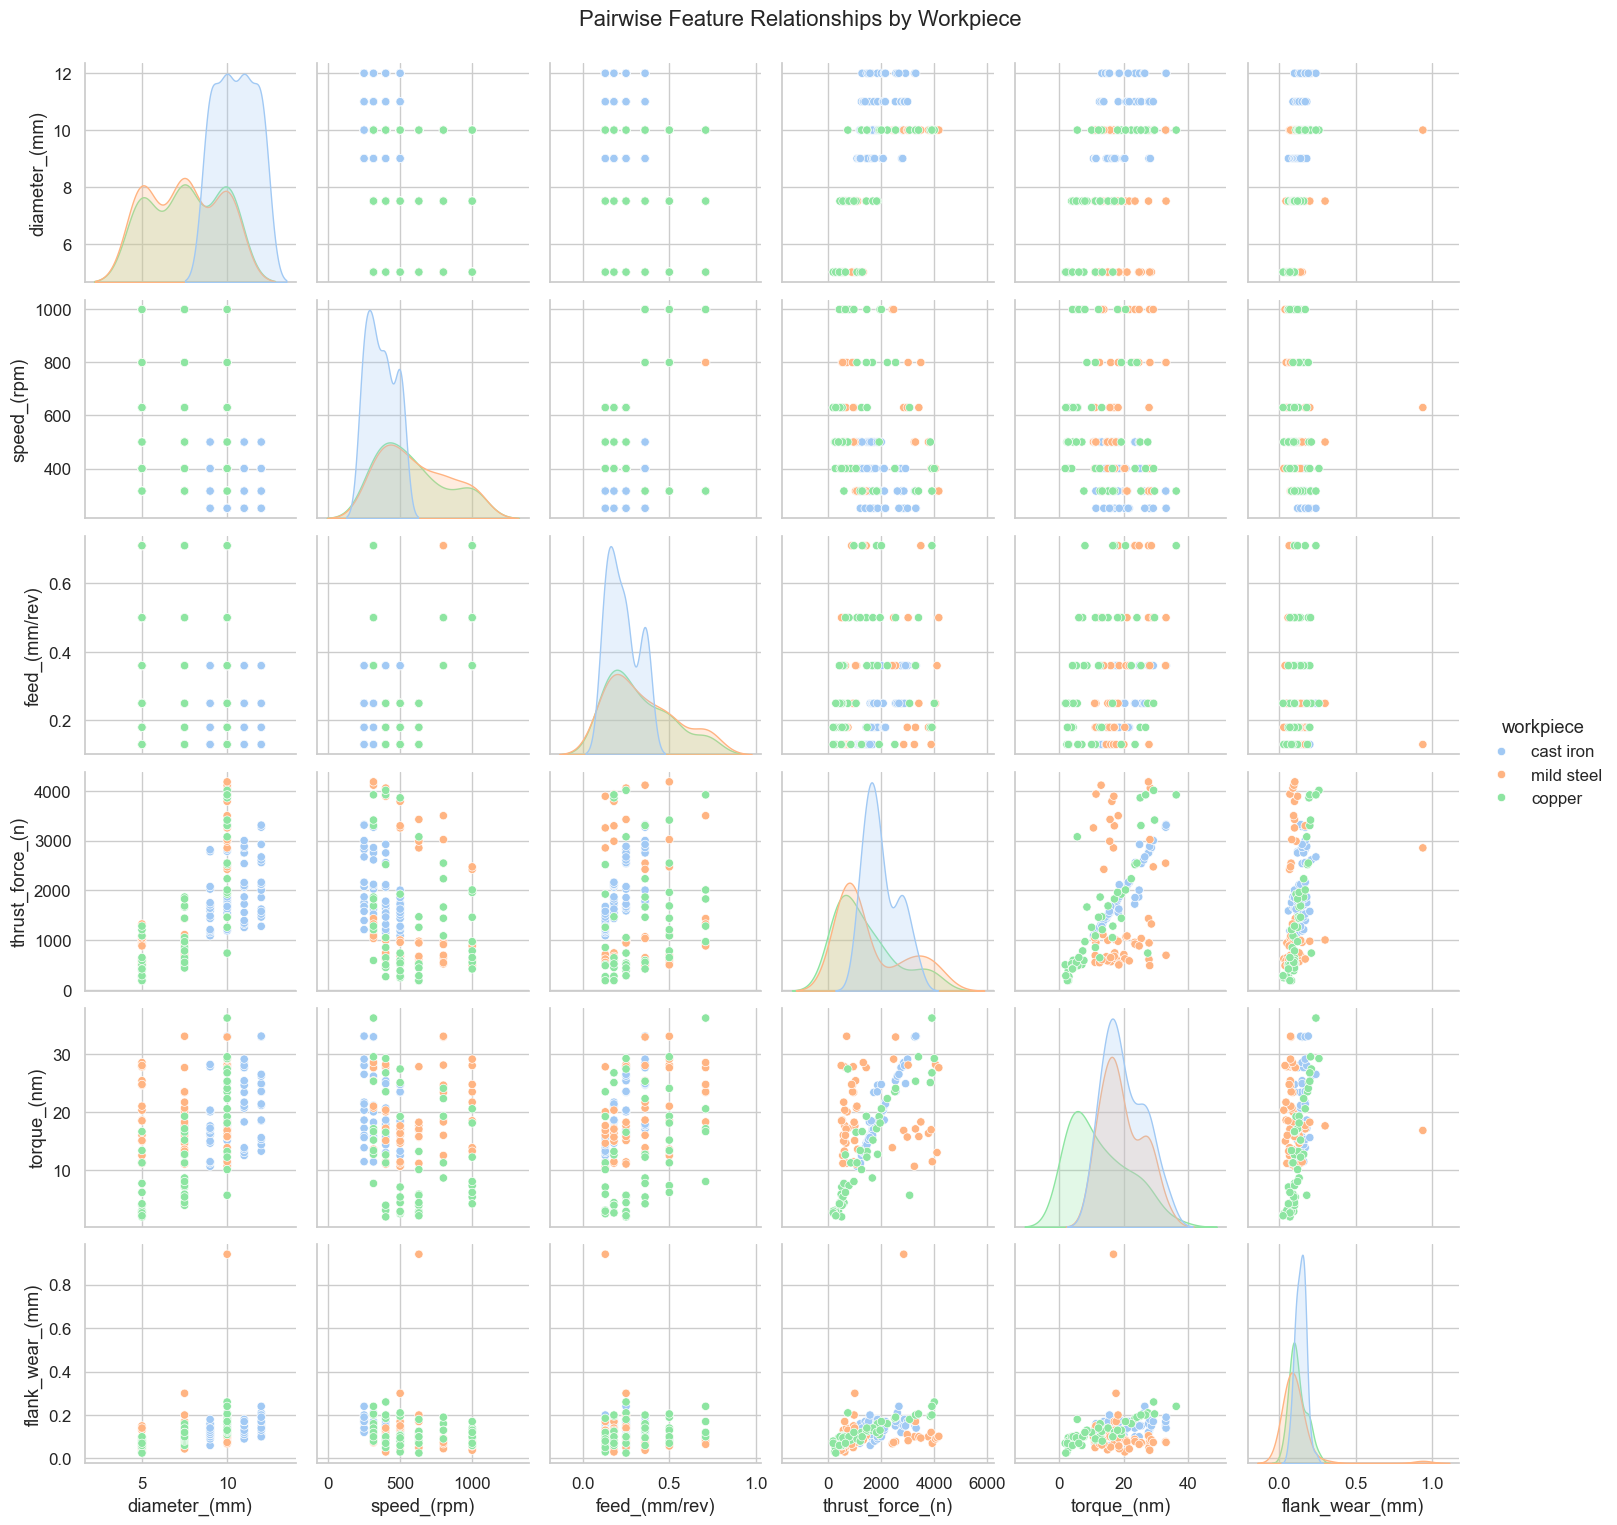

In [91]:
visualize(df_clean)

Interpretations from HEATMAP:

|Strong Positive Correlations:

->Thrust force (N) ↔ Diameter (mm): 0.67
Bigger tool diameters → Higher thrust force needed.
Insight: diameter contributes directly to cutting force requirements.

->Torque (Nm) ↔ Thrust force (N): 0.57
As expected — torque and thrust are often linked in drilling operations.
Insight: These could be redundant features in an ML model.

->Diameter (mm) ↔ Torque (Nm): 0.40
Torque increases as diameter increases — makes sense physically.

->Flank wear (mm) ↔ Thrust force (N): 0.37
Suggests that greater force leads to more wear.
Insight: Thrust force may be an important predictor of tool wear.

|Negative Correlations:

->Speed (rpm) ↔ Diameter (mm): -0.31
Likely a tradeoff — larger diameters may be used at lower speeds.
Insight: Could indicate optimization constraints in process planning.

->Speed (rpm) ↔ Thrust force (N): -0.31
Higher speeds reduce required force (maybe due to softening effect or better chip evacuation).


In [92]:
from src.clean_data import add_features
df_clean = add_features(df_clean)
X = df_clean[['diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)', 'speed_per_dia', 'log_feed']]


In [93]:
from tune_models import tune_random_forest

best_rf, best_params = tune_random_forest(X, y)
print("Best Params:", best_params)


Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [94]:
from src.model_train import train_models


In [95]:
X = df_clean[['diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)']]
y = df_clean[['thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)']]
results = train_models(X, y)

In [96]:
# View evaluation metrics
for model_name, metrics in results['metrics'].items():
    print(f"🔍 {model_name} Performance:")
    for metric_name, values in metrics.items():
        print(f"{metric_name}: {values}")
    print("-" * 40)

🔍 RandomForest Performance:
R2: [0.63685291 0.18926931 0.17623155]
MAE: [4.36749914e+02 6.04621357e+00 3.41645816e-02]
MSE: [3.65569289e+05 5.85500110e+01 1.61490841e-03]
----------------------------------------
🔍 XGBoost Performance:
R2: [ 0.7154863  -0.44961524 -0.14201963]
MAE: [3.866687e+02 7.326432e+00 3.881540e-02]
MSE: [2.8641141e+05 1.0468951e+02 2.2388054e-03]
----------------------------------------
